In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

from bokeh.plotting import figure, show, output_file, save
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
from bokeh.palettes import Viridis, Category10, Category20

In [2]:
from metamod.utils import ResultsManager, plot_lines

Loading BokehJS ...

In [3]:
results_path = "../results/cat_prop/run_id_1_MNIST_beta_5.0_21-01-2023_01-44-06-936"
#results_path = "../results/task_switch_less_reg_longer/slow_switch_run0_AffineCorrelatedGaussian_18-01-2023_19-32-18-232"
#results_path = '../results/task_engagement/run_id_9_MNIST-3_active_09-01-2023_06-40-14-613'
#results_path = '../results/cat_small_weights/run_id_1_MNIST_20-01-2023_04-21-08-620'
results = ResultsManager(results_path)

In [4]:
results.plot_control_optimization()

In [5]:
control = results.params["control_params"]["control"]

In [6]:
control.engagement_coef.shape

torch.Size([30000, 10])

# Use this numbers as class proportions in the training set

In [7]:
iters = results.results["iters"]
phis = [control.engagement_coef[:, i].detach().cpu().numpy() for i in range(control.engagement_coef.shape[1])]
colors = [Category10[10][i] for i in range(control.engagement_coef.shape[1])]
legends = ["C"+str(i) for i in range(control.engagement_coef.shape[1])]

s = plot_lines(iters, phis, labels=legends)
show(s)

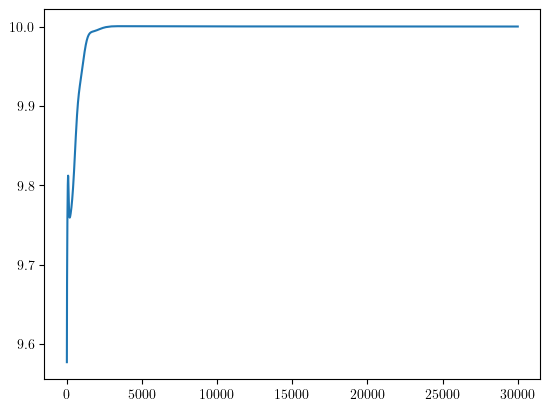

In [8]:
import matplotlib.pyplot as plt
plt.plot(np.sum(control.engagement_coef.detach().cpu().numpy(), axis=-1))

In [9]:
results.plot_loss()

In [10]:
class_proportions = control.engagement_coef.detach().cpu().numpy()

In [11]:
from metamod.networks import LinearNet
from metamod.tasks import MNISTClassMod, MNIST
from metamod.trainers import two_layer_training
from tqdm import tqdm

# Check batch sampling

In [12]:
dataset_params = {"batch_size": 512,
                  "new_shape": (5, 5),
                  "subset": (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
                  "class_proportions": class_proportions}
dataset_class = MNISTClassMod
model_params = {"learning_rate": 5e-2,
                "hidden_dim": 50,
                "intrinsic_noise": 0.0,
                "reg_coef": 0.0,
                "W1_0": None,
                "W2_0": None}
control_lr = 1.0
iter_control = 600
n_steps = 3000

In [13]:
dataset = dataset_class(**dataset_params)
balanced_dataset = MNIST(**{"batch_size": 1024,
                            "new_shape": (5, 5),
                            "subset": (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)})
model_params["input_dim"] = dataset.input_dim
model_params["output_dim"] = dataset.output_dim
model = LinearNet(**model_params)

/home/rodrigo/anaconda3/envs/metamod/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/rodrigo/anaconda3/envs/metamod/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/rodrigo/anaconda3/envs/metamod/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/rodrigo/anaconda3/envs/metamod/lib/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [14]:
n_tests = 2000
simulated_proportions = np.zeros((n_tests, 10))
for i in range(n_tests):
    x, y = dataset.sample_batch()
    y_label = np.argmax(y, axis=1)
    labels, counts = np.unique(y_label, return_counts=True)
    for j in range(10):
        simulated_proportions[i, j] = counts[j]/dataset.batch_size*10

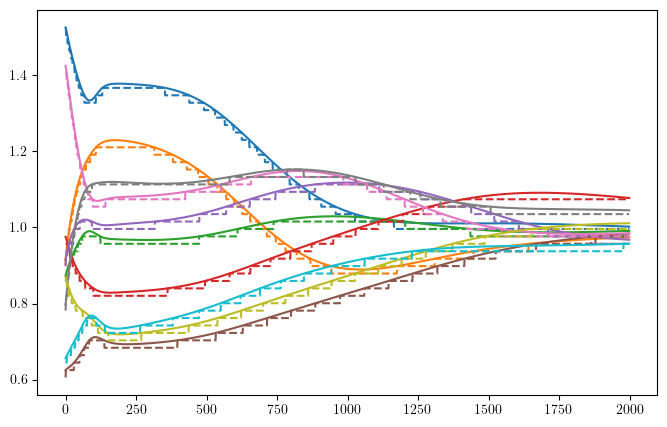

In [15]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))
for i in range(10):
    ax.plot(simulated_proportions[:, i], "C"+str(i)+"--")
    ax.plot(np.arange(n_tests), class_proportions[:n_tests, i], "C"+str(i))

In [16]:
def custom_training(model, dataset, balanced_dataset, n_steps, save_weights_every=100):

    loss = []
    iters = np.arange(n_steps)
    weights1 = []
    weights2 = []
    weights_iter = []
    balanced_loss = []

    for t in tqdm(range(n_steps)):
        x, y = dataset.sample_batch()
        b_x, b_y = balanced_dataset.sample_batch()
        current_loss = model.train_step(x, y)
        loss.append(current_loss.detach().cpu().numpy())
        balanced_loss.append(model.loss_function(b_x, b_y).detach().cpu().numpy())
        if t % save_weights_every == 0:
            weights1.append(model.W1.detach().cpu().numpy())
            weights2.append(model.W2.detach().cpu().numpy())
            weights_iter.append(t)

    return iters, np.array(loss), np.array(weights_iter), (np.array(weights1), np.array(weights2)), np.array(balanced_loss)

In [17]:
n_steps = 8000
save_weights_every = 20

dataset.reset_batch_sampling()
iters, loss, weights_iter, weights, balanced_loss = custom_training(model=model, dataset=dataset, balanced_dataset=balanced_dataset, 
                                                                    n_steps=n_steps, save_weights_every=save_weights_every)

results_dict = {}
results_dict["iters"] = iters
results_dict["Loss_t_sim"] = loss
results_dict["weights_sim"] = weights
results_dict["weights_iters_sim"] = weights_iter

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:20<00:00, 395.28it/s]


In [18]:
sim_loss = results.results["Loss_t_sim"]
class_prop_loss = loss

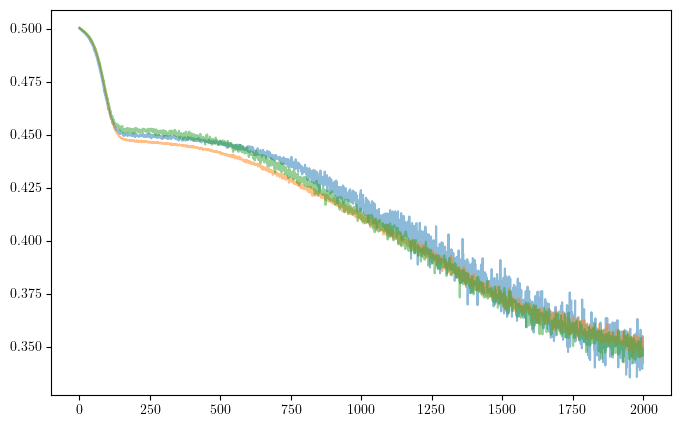

In [19]:
n_tests=2000
f, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(sim_loss[:n_tests], "C0", alpha=0.5)
ax.plot(class_prop_loss[:n_tests], "C1", alpha=0.5)
ax.plot(balanced_loss[:n_tests], "C2", alpha=0.5)
plt.show()